In [ ]:
# Core imports
import kagglehub
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

e:\MLOps\MLOps-Spotify\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load data from kaggle
data_path=kagglehub.dataset_download("amitanshjoshi/spotify-1million-tracks")
df=pd.read_csv(f"{data_path}/spotify_data.csv")

In [3]:
df.head()

,Unnamed: 0,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3
1,1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4
2,2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4
3,3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4
4,4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159764 entries, 0 to 1159763
Data columns (total 20 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Unnamed: 0        1159764 non-null  int64  
 1   artist_name       1159749 non-null  object 
 2   track_name        1159763 non-null  object 
 3   track_id          1159764 non-null  object 
 4   popularity        1159764 non-null  int64  
 5   year              1159764 non-null  int64  
 6   genre             1159764 non-null  object 
 7   danceability      1159764 non-null  float64
 8   energy            1159764 non-null  float64
 9   key               1159764 non-null  int64  
 10  loudness          1159764 non-null  float64
 11  mode              1159764 non-null  int64  
 12  speechiness       1159764 non-null  float64
 13  acousticness      1159764 non-null  float64
 14  instrumentalness  1159764 non-null  float64
 15  liveness          1159764 non-null  float64
 16  

In [5]:
df.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1159764.0,659061.322,428549.154,0.0,289940.750,579881.500,1031689.250,1473395.000
popularity,1159764.0,18.383,15.886,0.0,5.000,15.000,29.000,100.000
year,1159764.0,2011.955,6.804,2000.0,2006.000,2012.000,2018.000,2023.000
danceability,1159764.0,0.537,0.184,0.0,0.413,0.550,0.677,0.993
energy,1159764.0,0.640,0.271,0.0,0.454,0.694,0.873,1.000
key,1159764.0,5.288,3.555,0.0,2.000,5.000,8.000,11.000
loudness,1159764.0,-8.981,5.682,-58.1,-10.829,-7.450,-5.276,6.172
mode,1159764.0,0.635,0.482,0.0,0.000,1.000,1.000,1.000
speechiness,1159764.0,0.093,0.127,0.0,0.037,0.051,0.089,0.971
acousticness,1159764.0,0.322,0.355,0.0,0.006,0.147,0.640,0.996


In [6]:
df.isna().sum()

Unnamed: 0           0
artist_name         15
track_name           1
track_id             0
popularity           0
year                 0
genre                0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
time_signature       0
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(0)

In [3]:
# Handle missing values
df['artist_name'] = df['artist_name'].fillna('Unknown Artist')
df['track_name'] = df['track_name'].fillna('Unknown Track')

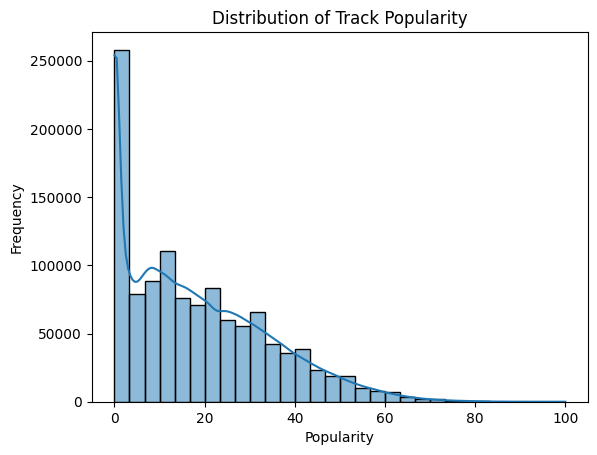

In [9]:
sns.histplot(df['popularity'], bins=30, kde=True)
plt.title('Distribution of Track Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.show()

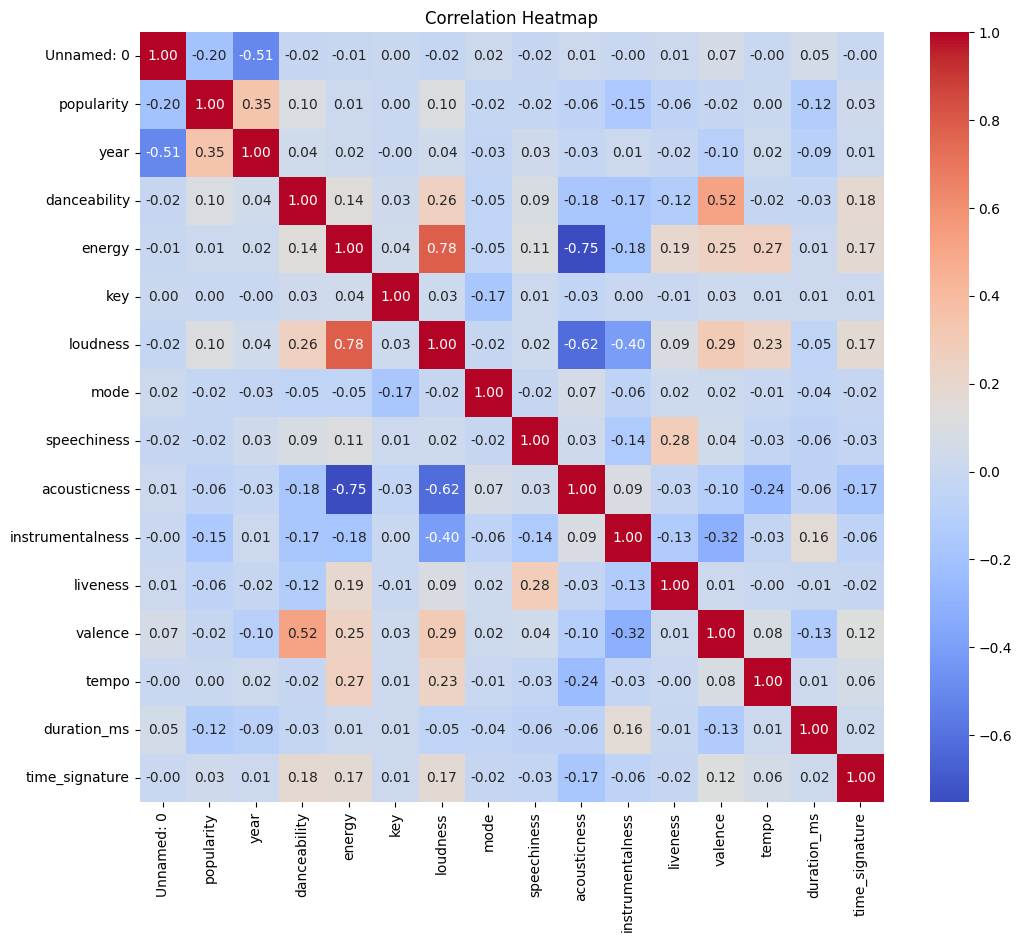

In [10]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [4]:
# Track age as a feature (EDA)
df['track_age'] = 2025 - df['year']

In [5]:
# Create binary target
df['is_popular'] = (df['popularity'] > 60).astype(int)

# Check class distribution
print(df['is_popular'].value_counts(normalize=True)*100)

is_popular
0    98.801998
1     1.198002
Name: proportion, dtype: float64


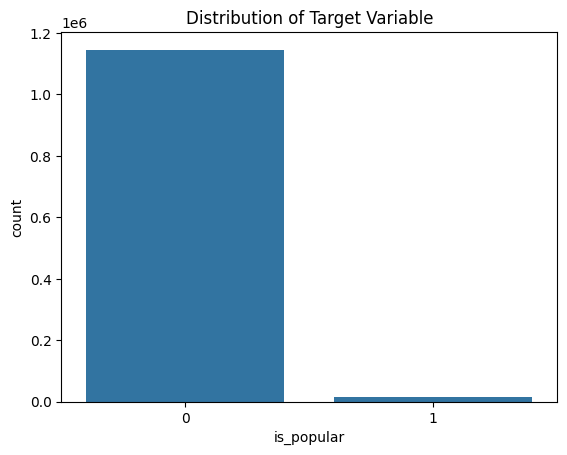

In [13]:
#show the ratio of target variable
df['is_popular'].value_counts(normalize=True)
sns.countplot(x='is_popular', data=df)
plt.title('Distribution of Target Variable')
plt.show()

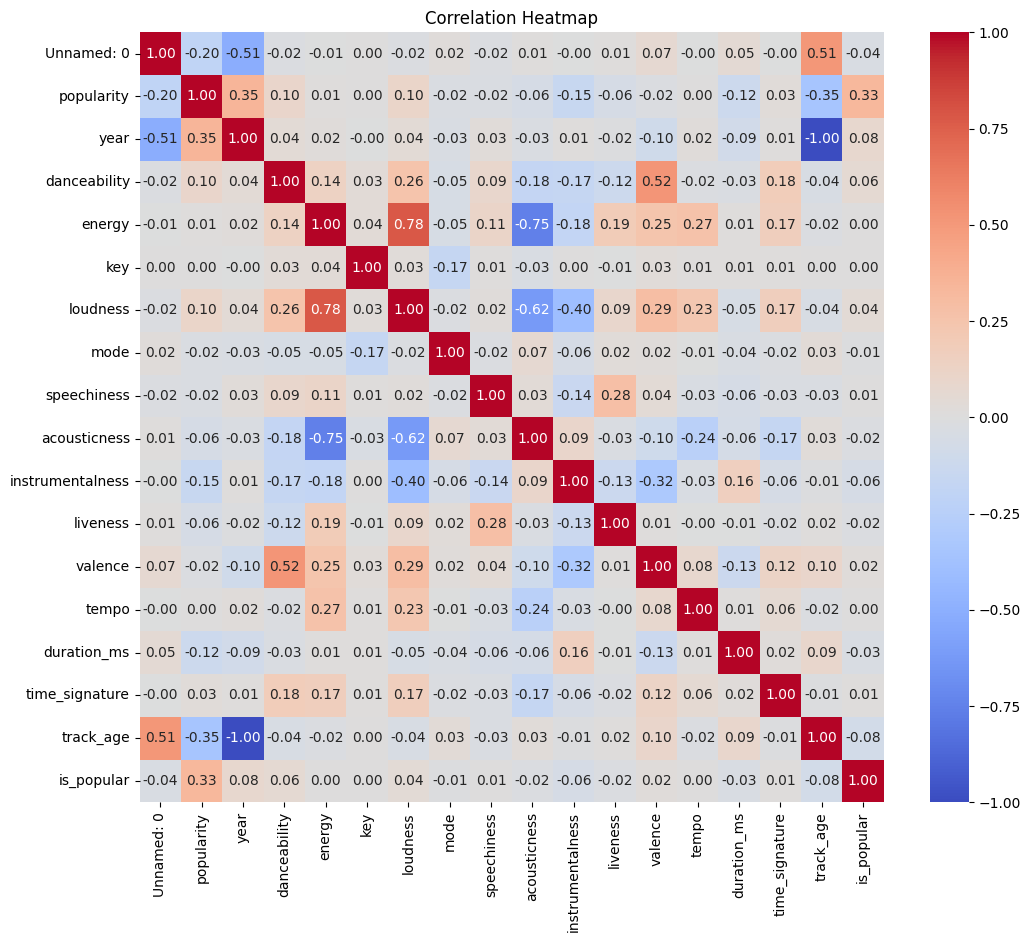

In [14]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [6]:
# Separate features from identifiers
df_artist = df.copy()
feature_columns = [col for col in df_artist.columns if col not in ['artist_name', 'track_name', 'genre', 'year']]
artist_features = df_artist[feature_columns].copy()
artist_identifiers = df_artist[['artist_name', 'track_name']].copy()

In [7]:
drop_cols = ['Unnamed: 0', 'year', 'track_id', 'track_name', 'artist_name', 'popularity']
df.drop(columns=drop_cols, inplace=True, errors='ignore')
df.head()

,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_age,is_popular
0,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3,13,1
1,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4,13,0
2,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4,13,0
3,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4,13,0
4,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4,13,0


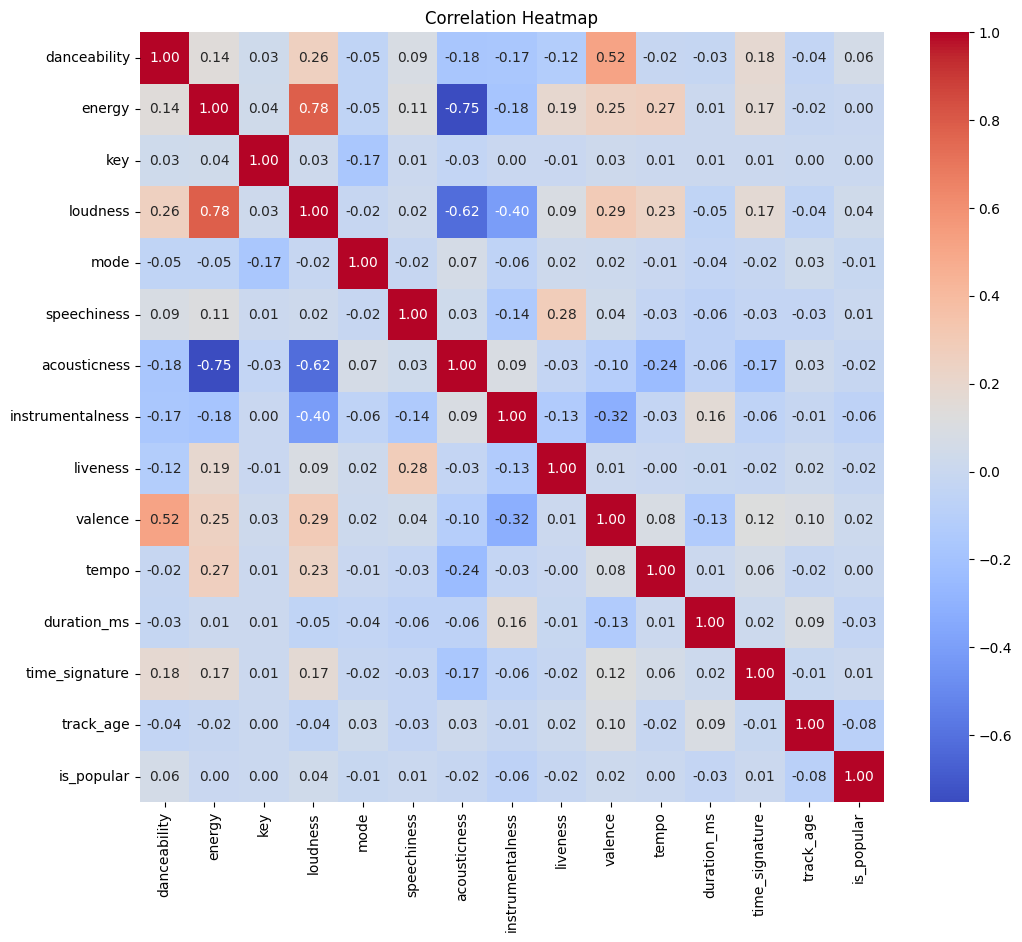

In [17]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159764 entries, 0 to 1159763
Data columns (total 16 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   genre             1159764 non-null  object 
 1   danceability      1159764 non-null  float64
 2   energy            1159764 non-null  float64
 3   key               1159764 non-null  int64  
 4   loudness          1159764 non-null  float64
 5   mode              1159764 non-null  int64  
 6   speechiness       1159764 non-null  float64
 7   acousticness      1159764 non-null  float64
 8   instrumentalness  1159764 non-null  float64
 9   liveness          1159764 non-null  float64
 10  valence           1159764 non-null  float64
 11  tempo             1159764 non-null  float64
 12  duration_ms       1159764 non-null  int64  
 13  time_signature    1159764 non-null  int64  
 14  track_age         1159764 non-null  int64  
 15  is_popular        1159764 non-null  int64  
dtype

In [8]:
TARGET = 'is_popular'
X = df.drop(columns=[TARGET], errors='ignore')
print(df.columns)
y = df[TARGET]

# Identify feature types
categorical_features = [col for col in ['genre'] if col in X.columns]
print(categorical_features)
numerical_features = [col for col in X.columns if col not in categorical_features]
print(numerical_features)

FEATURES = numerical_features + categorical_features

Index(['genre', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'track_age',
       'is_popular'],
      dtype='object')
['genre']
['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'track_age']


In [9]:
features_target = df[FEATURES + [TARGET]]
features_target.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_age,genre,is_popular
0,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3,13,acoustic,1
1,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4,13,acoustic,0
2,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4,13,acoustic,0
3,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4,13,acoustic,0
4,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4,13,acoustic,0


In [10]:
train_data, test_data = train_test_split(features_target, test_size=0.2, random_state=42, stratify=features_target[TARGET])

train_input = train_data[FEATURES]
train_output = train_data[TARGET]
test_input = test_data[FEATURES]
test_output = test_data[TARGET]
print(f"Data split: {len(train_input):,} training, {len(test_input):,} test samples")

Data split: 927,811 training, 231,953 test samples


In [11]:
numerical_transformer = Pipeline([
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("target_encoder", TargetEncoder(random_state=42))
])

preprocessor = ColumnTransformer([
    ("numerical", numerical_transformer, numerical_features),
    ("categorical", categorical_transformer, categorical_features),
])

In [12]:
def build_pipeline(estimator):
    return Pipeline([
        ("preprocessor", preprocessor),
        ("estimator", estimator),
    ])

In [13]:
rf = RandomForestClassifier(random_state=42)
# rf_param_grid = {
#     'estimator__n_estimators': [100, 200],
#     'estimator__max_depth': [10, 20, None],
#     'estimator__min_samples_split': [10, 20],
#     'estimator__min_samples_leaf': [4, 8]
# }

xgb = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_param_grid = {
    'estimator__n_estimators': [100, 200],
    'estimator__max_depth': [3, 6, 10],
    'estimator__learning_rate': [0.01, 0.1],
    'estimator__subsample': [0.8, 0.9]
}

In [ ]:
# mlflow.set_experiment("spotify_popularity_classification")

<Experiment: artifact_location='file:///e:/MLOps/MLOps-Spotify/notebook/mlruns/974618765784733486', creation_time=1763461256234, experiment_id='974618765784733486', last_update_time=1763461256234, lifecycle_stage='active', name='spotify_popularity_classification', tags={}>

In [15]:
def evaluate_mlflow(y_true, y_pred, y_pred_proba=None, run_name="model"):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Log core metrics
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall) 
    mlflow.log_metric("f1", f1)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    mlflow.log_metric("true_negatives", tn)
    mlflow.log_metric("false_positives", fp)
    mlflow.log_metric("false_negatives", fn) 
    mlflow.log_metric("true_positives", tp)
    
    # Rates
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    mlflow.log_metric("false_positive_rate", fpr)
    mlflow.log_metric("false_negative_rate", fnr)
    
    print(f"\n{run_name} Results:")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

In [ ]:
# mlflow.set_tracking_uri("http://localhost:4000")

In [ ]:
mlflow.set_experiment("spotify_popularity_classification")
mlflow.set_tracking_uri("http://localhost:4000")
# Train Random Forest (without tuning)
print("Training Random Forest (baseline)...")
rf_pipeline = build_pipeline(rf)
rf_pipeline.fit(train_input, train_output)
rf_predictions = rf_pipeline.predict(test_input)

with mlflow.start_run(run_name="random_forest_baseline"):
    mlflow.log_params(rf.get_params())
    evaluate_mlflow(test_output, rf_predictions, run_name="Random Forest Baseline")
    mlflow.sklearn.log_model(rf_pipeline, "random_forest_baseline")

Training Random Forest (baseline)...


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
xgb_pipeline = build_pipeline(xgb)
xgb_search = RandomizedSearchCV(
    xgb_pipeline,
    xgb_param_grid,
    n_iter=20,
    cv=cv_strategy,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print("Performing randomized search...")
xgb_search.fit(train_input, train_output)

best_xgb_pipeline = xgb_search.best_estimator_
best_xgb_params = xgb_search.best_params_
print(f"Best parameters (random search): {xgb_search.best_params_}")
print(f"Best cross-validation F1 score (random search): {xgb_search.best_score_:.4f}")

In [ ]:
# Evaluate best model
xgb_predictions = best_xgb_pipeline.predict(test_input)
xgb_predictions_proba = best_xgb_pipeline.predict_proba(test_input)[:, 1]

# Log to MLflow
with mlflow.start_run(run_name="xgboost_tuned"):
    # Log best parameters
    for param, value in best_xgb_params.items():
        mlflow.log_param(param, value)
    
    # Log cross-validation results
    mlflow.log_metric("best_cv_score", xgb_search.best_score_)
    mlflow.log_metric("cv_score_std", xgb_search.cv_results_['std_test_score'][xgb_search.best_index_])
    
    # Evaluate on test set
    evaluate_mlflow(test_output, xgb_predictions, xgb_predictions_proba, run_name="XGBoost Tuned")
    # Log the best model
    mlflow.sklearn.log_model(best_xgb_pipeline, "xgboost_tuned")